In [1]:
! git clone https://github.com/WongKinYiu/yolov7.git


Cloning into 'yolov7'...
remote: Enumerating objects: 1127, done.
remote: Total 1127 (delta 0), reused 0 (delta 0), pack-reused 1127
Receiving objects: 100% (1127/1127), 69.94 MiB | 42.55 MiB/s, done.
Resolving deltas: 100% (519/519), done.


In [2]:
%cd yolov7

/content/yolov7


In [3]:
! curl -L https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt -o yolov7-w6-pose.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  153M  100  153M    0     0  27.3M      0  0:00:05  0:00:05 --:--:-- 26.8M


In [4]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00


In [5]:
import torch
from torchvision import transforms
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts
from utils.torch_utils import select_device
from models.experimental import attempt_load

import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

# Video

In [17]:
def run(poseweights= 'yolov7-w6-pose.pt', source='pose.mp4', device='0'):

    path = source
    ext = path.split('/')[-1].split('.')[-1].strip().lower()
    if  ext.isnumeric():
        input_path = int(path)
        device = select_device(device)
        half = device.type != 'cpu'
        model = torch.load('yolov7-w6-pose.pt', map_location=device)['model']
        # Put in inference mode
        model.float().eval()
        if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
           model.half().to(device)

        cap = cv2.VideoCapture(input_path)

        frame_width, frame_height = int(cap.get(3)), int(cap.get(4))

        vid_write_image = letterbox(
            cap.read()[1], (frame_width), stride=64, auto=True)[0]
        resize_height, resize_width = vid_write_image.shape[:2]
        out_video_name = "output" if path.isnumeric else f"{input_path.split('/')[-1].split('.')[0]}"
        out = cv2.VideoWriter(f"{out_video_name}_result4.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (resize_width, resize_height))

        frame_count, total_fps = 0, 0

        while cap.isOpened:

            print(f"Frame {frame_count} Processing")
            ret, frame = cap.read()
            if ret:
                orig_image = frame

                # preprocess image
                image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
                image = letterbox(image, (frame_width), stride=64, auto=True)[0]
                image_ = image.copy()
                image = transforms.ToTensor()(image)
                image = torch.tensor(np.array([image.numpy()]))

                image = image.type(torch.cuda.HalfTensor)
                start_time = time.time()

                with torch.no_grad():
                    output, _ = model(image)

                output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
                output = output_to_keypoint(output)
                img = image[0].permute(1, 2, 0) * 255
                img = img.cpu().numpy().astype(np.uint8)

                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                for idx in range(output.shape[0]):
                    plot_skeleton_kpts(img, output[idx, 7:].T, 3)

                if ext.isnumeric():
                    cv2.imshow("Detection", img)
                    key = cv2.waitKey(1)
                    if key == ord('c'):
                        break

                end_time = time.time()
                fps = 1 / (end_time - start_time)
                total_fps += fps
                frame_count += 1
                out.write(img)
            else:
                break

        cap.release()
        avg_fps = total_fps / frame_count
        print(f"Average FPS: {avg_fps:.3f}")


# colab webcam

In [6]:
def load_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load('yolov7-w6-pose.pt', map_location=device)['model']
    # Put in inference mode
    model.float().eval()
    if torch.cuda.is_available():
      # half() turns predictions into float16 tensors
      # which significantly lowers inference time
      model.half().to(device)
    return model

model = load_model()

In [ ]:
def run_inference(url):
    image = cv2.imread(url) 
    # Resize and pad image
    image = letterbox(image, 640, stride=64, auto=True)[0] 
    # Apply transforms
    image = transforms.ToTensor()(image) 
    image = image.cuda()
    # Turn image into batch
    image = image.unsqueeze(0) 
    output, _ = model(image) 
    return output, image

In [ ]:
def visualize_output(output, image):
    output = non_max_suppression_kpt(output, 
                                     0.25, # Confidence Threshold
                                     0.65, # IoU Threshold
                                     nc=model.yaml['nc'], # Number of Classes
                                     nkpt=model.yaml['nkpt'], # Number of Keypoints
                                     kpt_label=True)
    with torch.no_grad():
        output = output_to_keypoint(output)
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    result=nimg
    plt.imshow(nimg)
    plt.show()
    return result

In [7]:
def video_output(frame):
    image = frame
    # Resize and pad image
    image = letterbox(image, 640, stride=64, auto=True)[0] 
    # Apply transforms
    image = transforms.ToTensor()(image) 
    image = image.type(torch.cuda.HalfTensor)
    # Turn image into batch
    image = image.unsqueeze(0) 
    output, _ = model(image)
    output = non_max_suppression_kpt(output, 
                                     0.25, # Confidence Threshold
                                     0.65, # IoU Threshold
                                     nc=model.yaml['nc'], # Number of Classes
                                     nkpt=model.yaml['nkpt'], # Number of Keypoints
                                     kpt_label=True)
    with torch.no_grad():
        output = output_to_keypoint(output)
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
    return nimg

In [8]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io

In [9]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
  # function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img
  # function to convert OpenCV bounding box image into base64 byte string to be overlayed on video stream

<IPython.core.display.Javascript object>

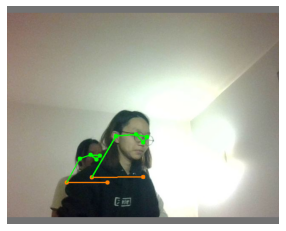

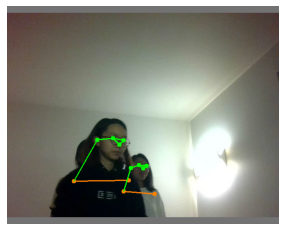

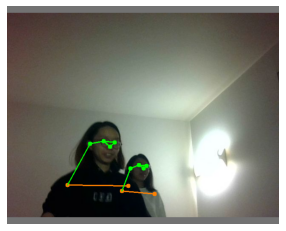

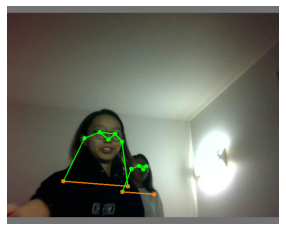

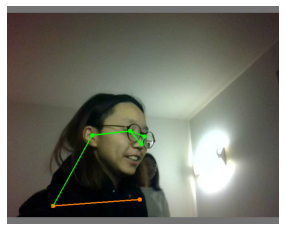

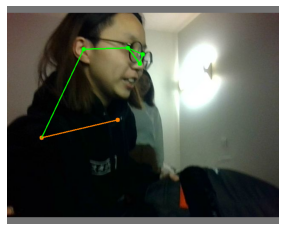

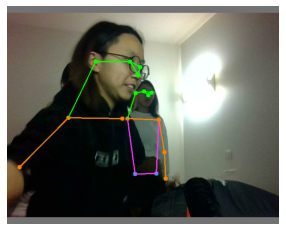

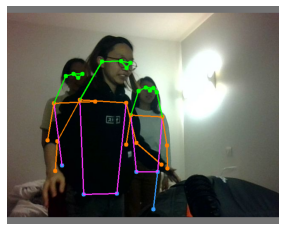

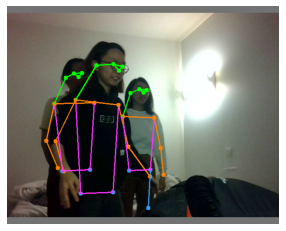

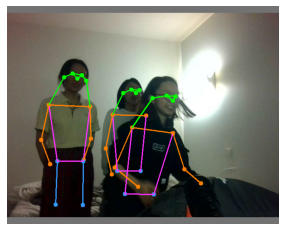

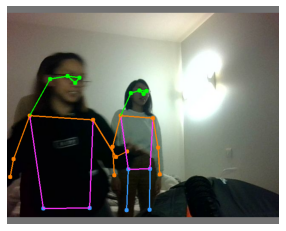

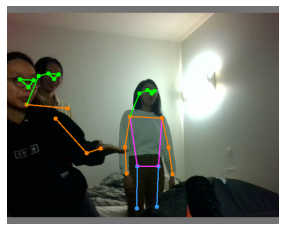

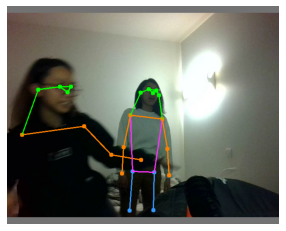

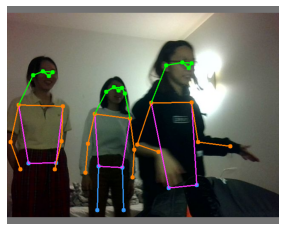

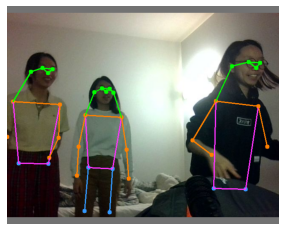

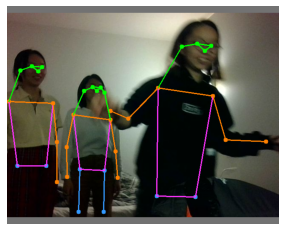

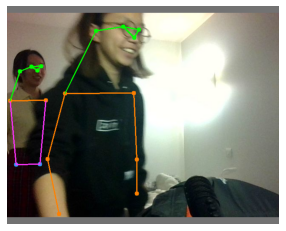

In [14]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    nimg=video_output(frame)
    fig, ax = plt.subplots()
    # Plot the current image on the axis
    ax.cla()
    im = ax.imshow(nimg)
    im.set_data(nimg)
    ax.set_axis_off()